In [31]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [32]:
df=pd.read_csv("/kaggle/input/rossmann-store-sales/train.csv")
df2=pd.read_csv("/kaggle/input/rossmann-store-sales/test.csv")
st=pd.read_csv("/kaggle/input/rossmann-store-sales/store.csv")

print(df.head())
print(df2.head())
print(st.head())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2

/tmp/ipykernel_36/3053471156.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/kaggle/input/rossmann-store-sales/train.csv")
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Merge store dataset with test and train

In [33]:
mr_train=pd.merge(df,st,on="Store")
mr_test=pd.merge(df2,st,on="Store")
mr_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [34]:
print(mr_train.isnull().sum())
print(mr_train["CompetitionDistance"].value_counts())


Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64
CompetitionDistance
250.0      11120
350.0       7536
50.0        7536
1200.0      7374
190.0       7352
           ...  
3920.0       758
4460.0       758
13090.0      758
5890.0       758
12870.0      758
Name: count, Length: 654, dtype: int64


In [35]:
for df in [mr_train, mr_test]:
    df["CompetitionDistance"] = pd.to_numeric(df["CompetitionDistance"], errors='coerce')
    df["CompetitionOpenSinceMonth"] = pd.to_numeric(df["CompetitionOpenSinceMonth"], errors='coerce')
    df["CompetitionOpenSinceYear"] = pd.to_numeric(df["CompetitionOpenSinceYear"], errors='coerce')
    df["Promo2SinceWeek"] = pd.to_numeric(df["Promo2SinceWeek"], errors='coerce')
    df["Promo2SinceYear"] = pd.to_numeric(df["Promo2SinceYear"], errors='coerce')

In [36]:
for df in [mr_train, mr_test]:
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(230.0)          # median
    df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(9)  # mode
    df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(2010) # mode
    df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0)
    df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0)
    df["PromoInterval"] = df["PromoInterval"].fillna("NoPromo")

In [37]:
print("Train Nulls:\n", mr_train.isnull().sum())
print("\nTest Nulls:\n", mr_test.isnull().sum())

Train Nulls:
 Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Test Nulls:
 Id                            0
Store                         0
DayOfWeek                     0
Date                          0
Open                         11
Promo                         0
StateHoliday                  0
SchoolHoliday                 0
StoreType                     0
Assortment                    0
CompetitionDistance           0
CompetitionOpenSinceMonth     0
CompetitionOpenSi

In [38]:
print("head of train\n",mr_test.head())
print("head of test\n",mr_train.head())

head of train
    Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday  \
0   1      1          4  2015-09-17   1.0      1            0              0   
1   2      3          4  2015-09-17   1.0      1            0              0   
2   3      7          4  2015-09-17   1.0      1            0              0   
3   4      8          4  2015-09-17   1.0      1            0              0   
4   5      9          4  2015-09-17   1.0      1            0              0   

  StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0         c          a               1270.0                        9.0   
1         a          a              14130.0                       12.0   
2         a          c              24000.0                        4.0   
3         a          a               7520.0                       10.0   
4         a          c               2030.0                        8.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo

In [39]:
def ExtractDate(data):
    data['Date'] = pd.to_datetime(data['Date'])

    # Step 2: Feature engineering
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['WeekOfYear'] = data['Date'].dt.isocalendar().week
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 6 else 0)
    data.drop(['Date','Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace=True)
   
ExtractDate(mr_train)
ExtractDate(mr_test)

print("head of test data\n",mr_test)
print("head of train data\n",mr_train)
    

head of test data
           Id  Store  DayOfWeek  Open  Promo StateHoliday  SchoolHoliday  \
0          1      1          4   1.0      1            0              0   
1          2      3          4   1.0      1            0              0   
2          3      7          4   1.0      1            0              0   
3          4      8          4   1.0      1            0              0   
4          5      9          4   1.0      1            0              0   
...      ...    ...        ...   ...    ...          ...            ...   
41083  41084   1111          6   1.0      0            0              0   
41084  41085   1112          6   1.0      0            0              0   
41085  41086   1113          6   1.0      0            0              0   
41086  41087   1114          6   1.0      0            0              0   
41087  41088   1115          6   1.0      0            0              1   

      StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0 

In [40]:
print(mr_train[['Year', 'Month', 'Day', 'WeekOfYear', 'IsWeekend']].sample(5))

        Year  Month  Day  WeekOfYear  IsWeekend
940497  2013      3   10          10          1
961398  2013      2   20           8          0
652440  2013     11   24          47          1
330891  2014      9   21          38          1
171714  2015      2   27           9          0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


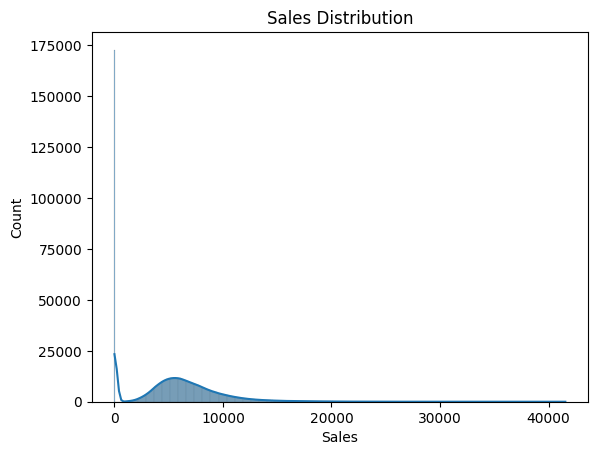

In [41]:
# Example for Sales
sns.histplot(mr_train['Sales'], kde=True)
plt.title("Sales Distribution")
plt.show()

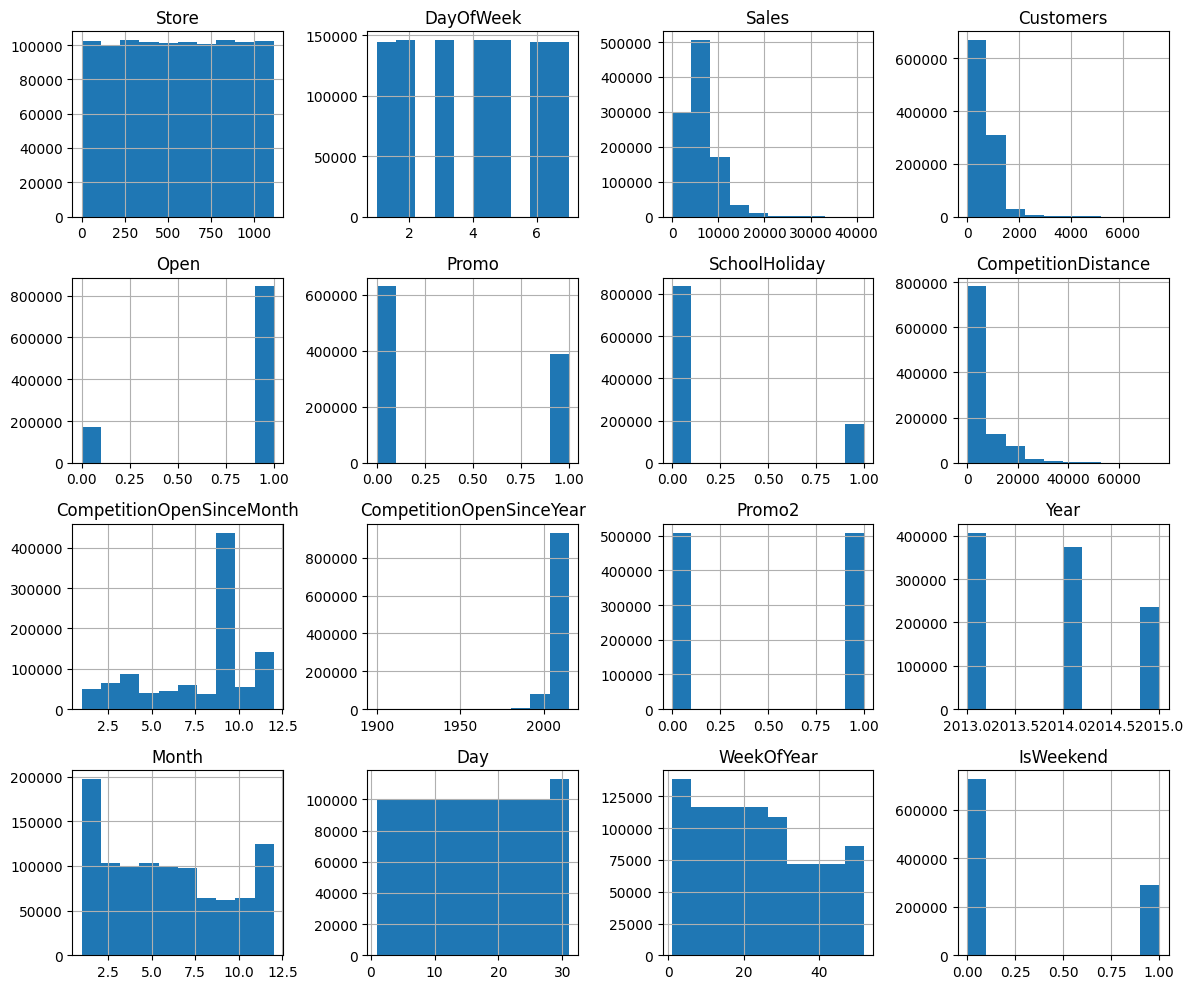

In [42]:
mr_train.select_dtypes(include='number').hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


In [43]:
# Log transform
mr_train['Sales'] = np.log1p(mr_train['Sales'])
mr_train['CompetitionDistance'] = np.log1p(mr_train['CompetitionDistance'])




In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in ['StoreType', 'PromoInterval', 'Assortment', 'StateHoliday']:
    mr_train[col] = le.fit_transform(mr_train[col].fillna('None').astype(str))
    mr_test[col] = le.transform(mr_test[col].fillna('None').astype(str))


In [45]:
X = mr_train.drop(columns=['Sales','Customers'], axis=1)
y = mr_train['Sales']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
mr_test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend
0,1,1,4,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,3,2015,9,17,38,0
1,2,3,4,1.0,1,0,0,0,0,14130.0,12.0,2006.0,1,1,2015,9,17,38,0
2,3,7,4,1.0,1,0,0,0,2,24000.0,4.0,2013.0,0,3,2015,9,17,38,0
3,4,8,4,1.0,1,0,0,0,0,7520.0,10.0,2014.0,0,3,2015,9,17,38,0
4,5,9,4,1.0,1,0,0,0,2,2030.0,8.0,2000.0,0,3,2015,9,17,38,0


In [47]:
mr_test.drop(columns=['Id'],inplace=True)

In [48]:
# Model
model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)


In [49]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Log RMSE:", rmse)

Log RMSE: 0.16378479758150424


Reverse log1p to get actual scale RMSE

In [52]:

rmse_actual = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
print("Actual RMSE (Sales scale):", rmse_actual)

Actual RMSE (Sales scale): 1097.813369625831


In [55]:
y_test_pred = model.predict(mr_test)
y_test_pred = np.expm1(y_test_pred)
y_test_pred

array([ 5160.023 ,  5930.821 ,  7515.8105, ..., 10912.982 , 10912.982 ,
        5465.5156], dtype=float32)

In [59]:
submission = pd.DataFrame({
    "Id": range(1, len(y_test_pred)+1),
    "PredictedSales": y_test_pred
})

submission.to_csv("Sales_Predictions.csv", index=False)
